In [1]:
import pymysql
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import jieba
%matplotlib inline

In [119]:
# CAVEAT: Chinese font problem under MacOS
# Install attached SimHei.ttf in Font Book
# Restart Jupyter notebook in terminal
mpl.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']

# font size
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 24

# colormap
BLUE = '#73b1f4'
DARK_BLUE = '#003366'
GREEN = '#62ddbd'
DARK_GREEN = '#35bb9b'
BLUE2 = '#99ccff'
DARK_BLUE2 = '#333399'
GRAY = '#dddddd'

In [3]:
#connect to mysql
connect = pymysql.Connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    passwd='1234',
    db='dynamicdb',
    charset='utf8'
)

In [4]:
#fetch data from table bangumi 
b = pd.read_sql("select * from bangumi",con=connect)

In [5]:
#fetch data from table episode
e = pd.read_sql("select * from episode",con=connect)

# season-level statistics

In [6]:
## number of seasons
print('There are {:d} seasons in total'.format(len(b)))

There are 884 seasons in total


In [7]:
#expand tag values 
tag_expand = b.tags.str.split('|',expand=True).stack().reset_index(level=1,drop=True)

#calc number of tags
print(' {:d} different tags in our dataset'.format(tag_expand.nunique()))

 43 different tags in our dataset


In [8]:
### tags of episodes
b['tag_cnt'] = b.tags.apply(lambda x: len(x.split('|')))
print('each season is assigned {:.2f} tags on average'.format(b.tag_cnt.mean()))

each season is assigned 3.13 tags on average


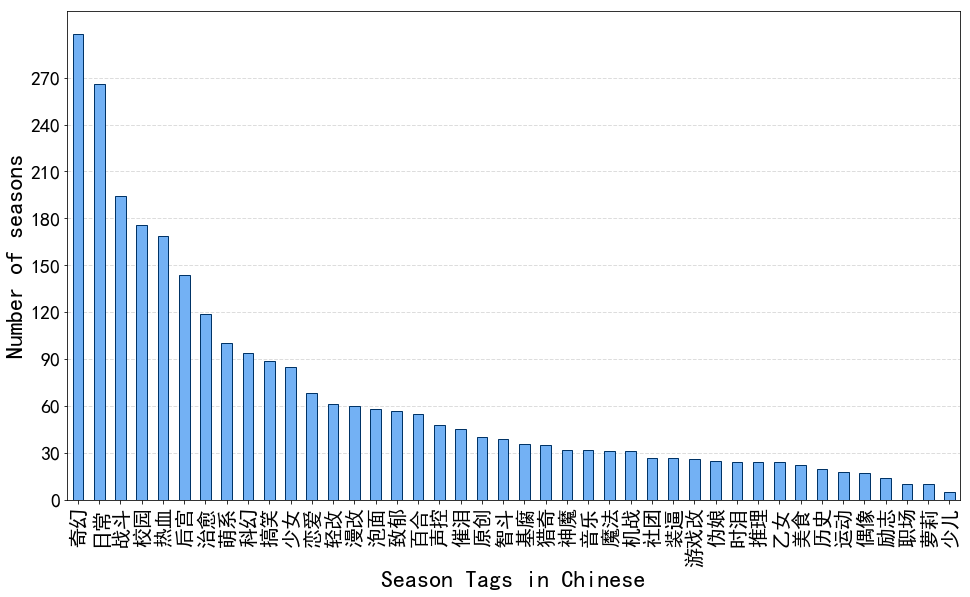

In [120]:
#count numbers of season with different tags
tag_expand.value_counts().drop('').plot(kind='bar', figsize=(16,9), color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=22)
mpl.rcParams['axes.labelsize'] = 28
plt.yticks(np.arange(0, 300, 30))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Season Tags in Chinese')
plt.ylabel('Number of seasons')
plt.savefig('Figure_2a.pdf', bbox_inches='tight')

# episode-level statistics

In [10]:
## number of episodes
print('There are {:d} episodes in total'.format(len(e)))

There are 17870 episodes in total


In [11]:
## averge no. of episodes per season
b_e = e.groupby('season_id').count().iloc[:,1].reset_index()
b_e.rename(columns={b_e.columns[1]:'episode_cnt'}, inplace=True)
print('average {:.2f} episodes per season '.format(b_e.episode_cnt.mean()))

average 19.88 episodes per season 


In [72]:
#calc length of each episode
sql = "select episode_id, max(playback_time) as max_time from danmaku group by episode_id;"
e_duration = pd.read_sql(sql,con=connect)

# length of episodes in total
print('total length of episodes(h):{:.0f}'.format(e_duration.max_time.sum()/3600))

total length of episodes(h):47836


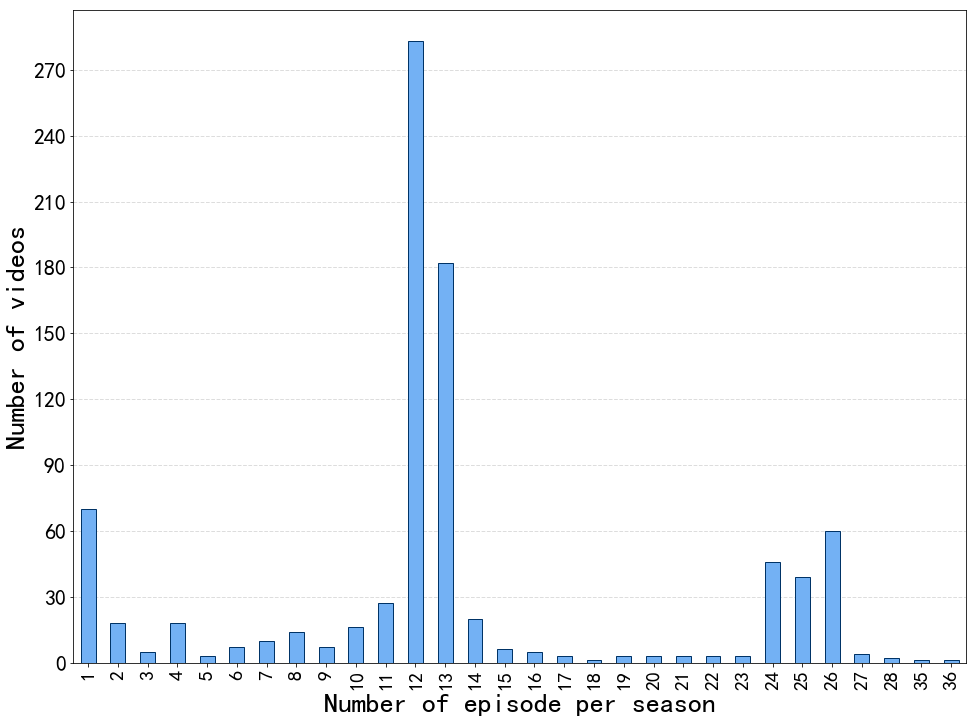

In [121]:
#Distribution of number of episodes per season 
b_e = e.groupby('season_id').count().iloc[:,1].reset_index()
b_e.rename(columns={b_e.columns[1]:'episode_cnt'}, inplace=True)
b_e.episode_cnt.value_counts().sort_index()[0:30].plot(kind='bar', figsize=(16,12), color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(0, 300, 30))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
ax.set_xlabel( 'Number of episode per season')
ax.set_ylabel('Number of videos')
plt.savefig('Figure_3a.pdf', bbox_inches='tight')

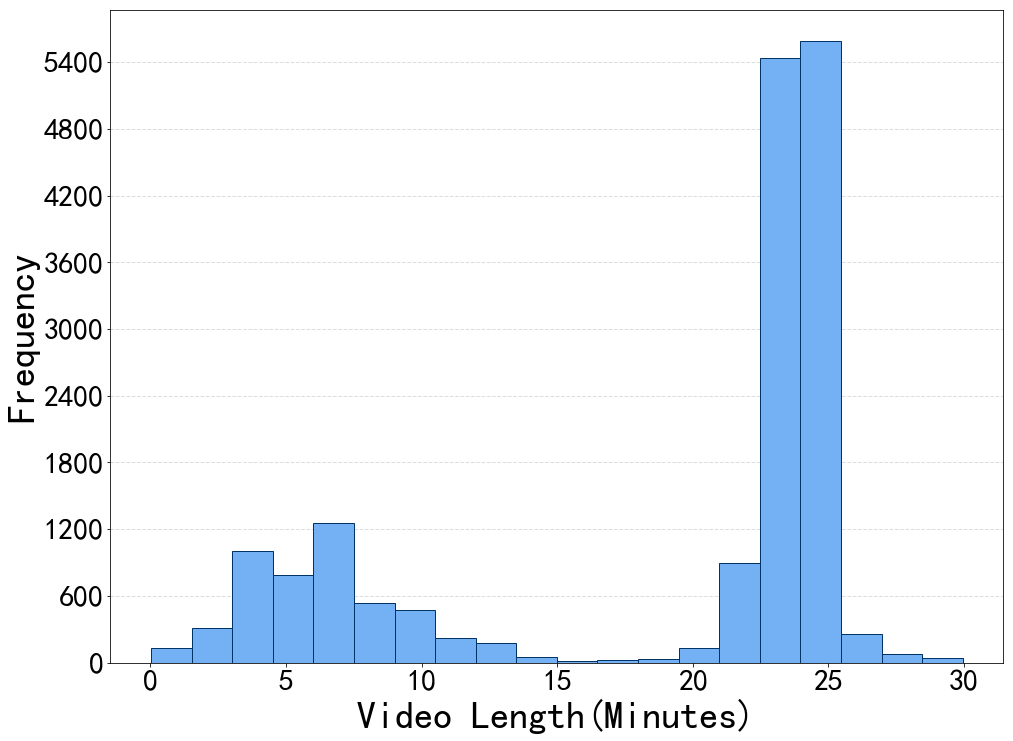

In [122]:
# distribution of video length per season
(e_duration.max_time/60)[e_duration.max_time/60 <= 30].hist(
    bins=20,figsize=(16,12),grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(0, 6000, 600))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Video Length(Minutes)')
plt.ylabel('Frequency')
plt.savefig('Figure_3b.pdf', bbox_inches='tight')

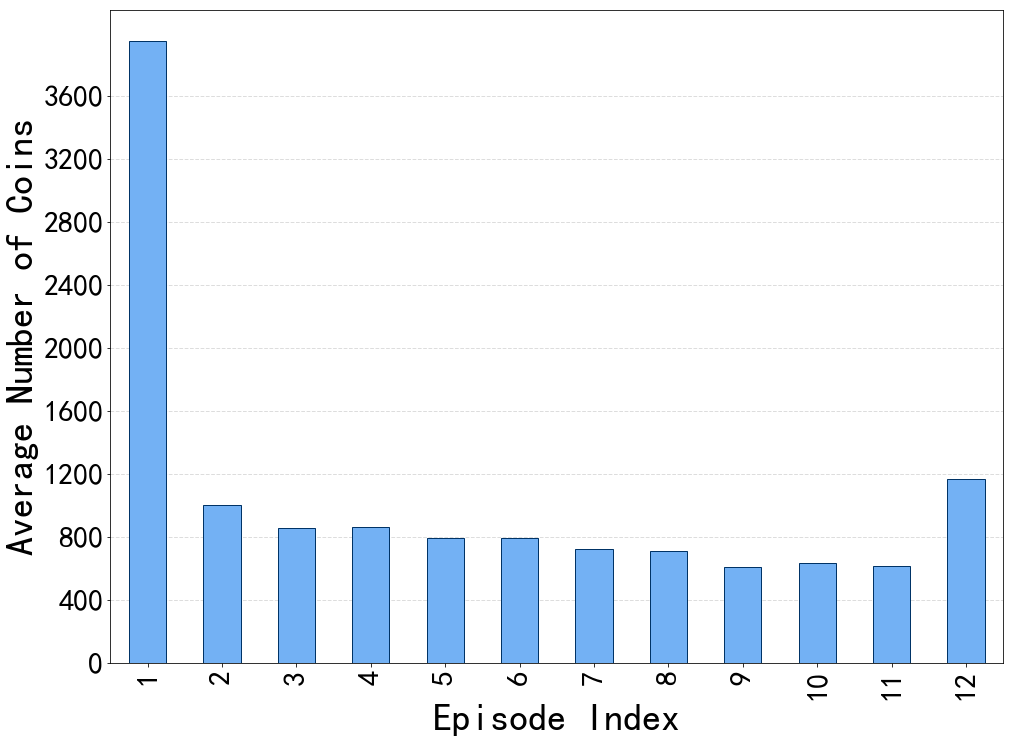

In [156]:
# One useful attribute of episode is ”coins” representing how many users like the episode 
# and average count of coins per episode index is shown in figure 3c.

#average of coins per episode

e.groupby('index')['coins'].mean()[['1','2','3','4','5','6','7','8','9','10','11','12']]\
    .plot(kind='bar', figsize=(16,12),grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(0, 4000, 400))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Episode Index')
plt.ylabel('Average Number of Coins')
plt.savefig('Figure_3c.pdf', bbox_inches='tight')

## TSC-level statistics

In [113]:
#distribution of TSC in seasons
sql = '''
select b.season_id, sum(danmaku_cnt) as danmaku_cnt
from
(
	select episode_id, count(*) as danmaku_cnt
	from danmaku 
	group by episode_id
)a 
inner join 
(
	select episode_id, season_id 
	from episode
)b
on a.episode_id = b.episode_id
group by b.season_id
;
'''
season_danmaku_cnt = pd.read_sql(sql,con=connect)

print('averge：{:.0f} TSC per season'.format(season_danmaku_cnt.danmaku_cnt.mean()))

averge：36651 TSC per season


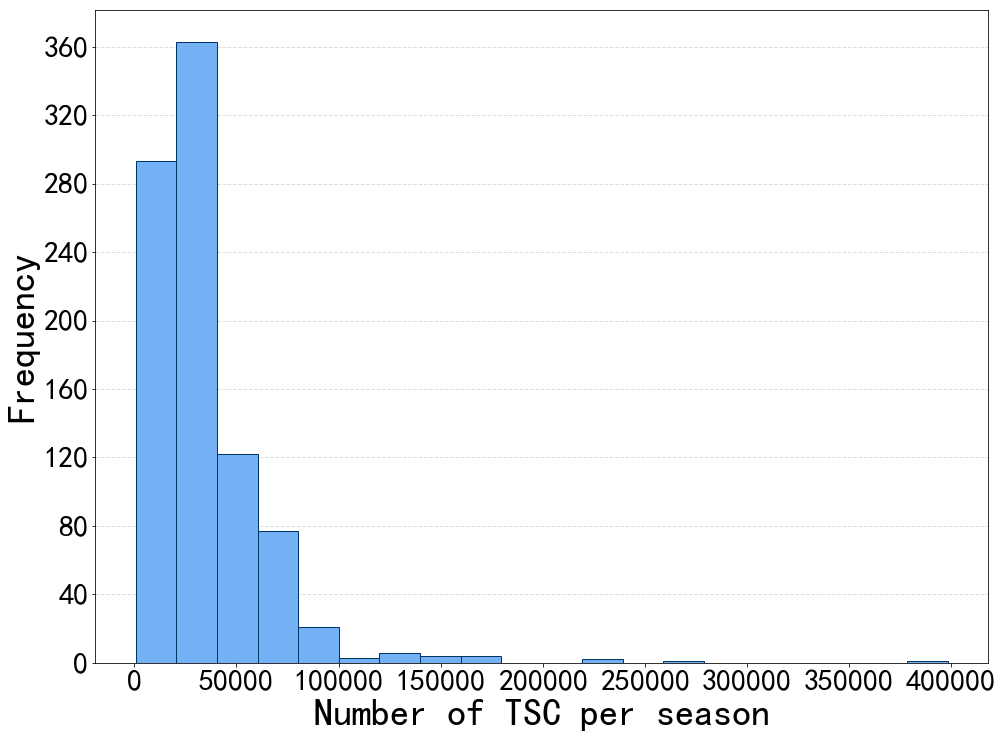

In [125]:
#number of TSC per season, 4a
season_danmaku_cnt[season_danmaku_cnt.danmaku_cnt<400000]\
    .danmaku_cnt.hist(bins=20, figsize=(16,12), grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(0, 400, 40))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Number of TSC per season')
plt.ylabel('Frequency')
plt.savefig('Figure_4a.pdf', bbox_inches='tight')

In [126]:
#distribution of TSC in episodes
e_d = pd.read_sql("select episode_id, count(*) as danmaku_cnt from danmaku group by episode_id;",con=connect)
print('averge：{:.0f} TSC per episode'.format(e_d.danmaku_cnt.mean()))

averge：1857 TSC per episode


In [127]:
# number of TSC in total
print('total count of TSC: {:d}'.format(pd.read_sql("select count(*) from danmaku;",con=connect).iloc[0,0]))

total count of TSC: 32949297


In [128]:
print('each TSC has {:.2f} Chinese characters on average' \
          .format(pd.read_sql("select avg(char_length(content)) from danmaku limit 10;",con=connect).iloc[0,0]))

each TSC has 8.71 Chinese characters on average


In [129]:
#find corresponding season info for each episode
e_d = e_d.merge(e[['episode_id','season_id','index']], on = 'episode_id')
e_d = e_d.merge(b[['season_id','total_count']], on = 'season_id')
e_d = e_d.merge(b_e, on='season_id')

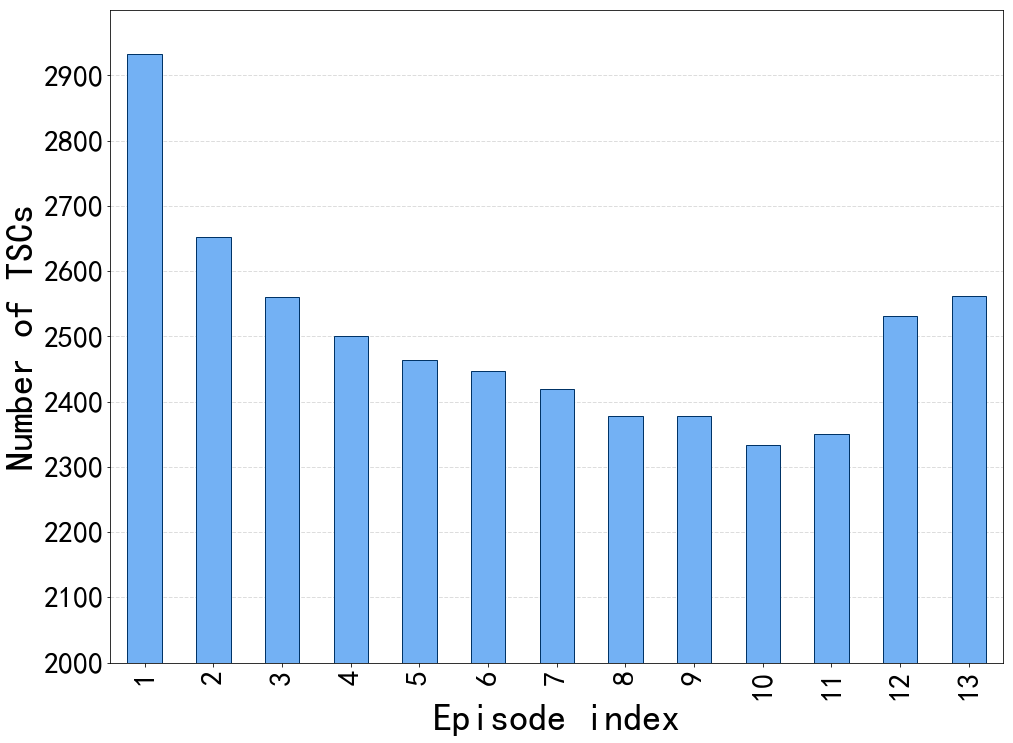

In [132]:
#find seasons with 12 or 13 episodes 
episode_12_13 = e_d[(e_d.episode_cnt == 12) | (e_d.episode_cnt == 13)]

# make sure the season is finished
episode_12_13=episode_12_13[episode_12_13.total_count == episode_12_13.episode_cnt]

### TSC changing with episodes (limited to seasons with length 12/13)
episode_12_13['index'] = episode_12_13['index'].apply(pd.to_numeric, errors='coerce')

episode_12_13.groupby('index')['danmaku_cnt'].mean().sort_index()[1:14]. \
    plot(kind='bar',ylim=(2000,3000), figsize=(16,12), grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(2000, 3000, 100))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Episode index')
plt.ylabel('Number of TSCs')
plt.savefig('Figure_4b.pdf', bbox_inches='tight')

In [133]:
#find seasons with 12 episodes 
episode_12 = e_d[(e_d.episode_cnt == 12) ]
episode_12 = episode_12[episode_12.total_count == episode_12.episode_cnt]
episode_12['index'] = episode_12['index'].apply(pd.to_numeric, errors='coerce')

In [136]:
#episode_12.groupby('index')['danmaku_cnt'].mean().sort_index()[0:12].plot(kind='bar', ylim=(2000,3000),grid=True)
#plt.xlabel('')

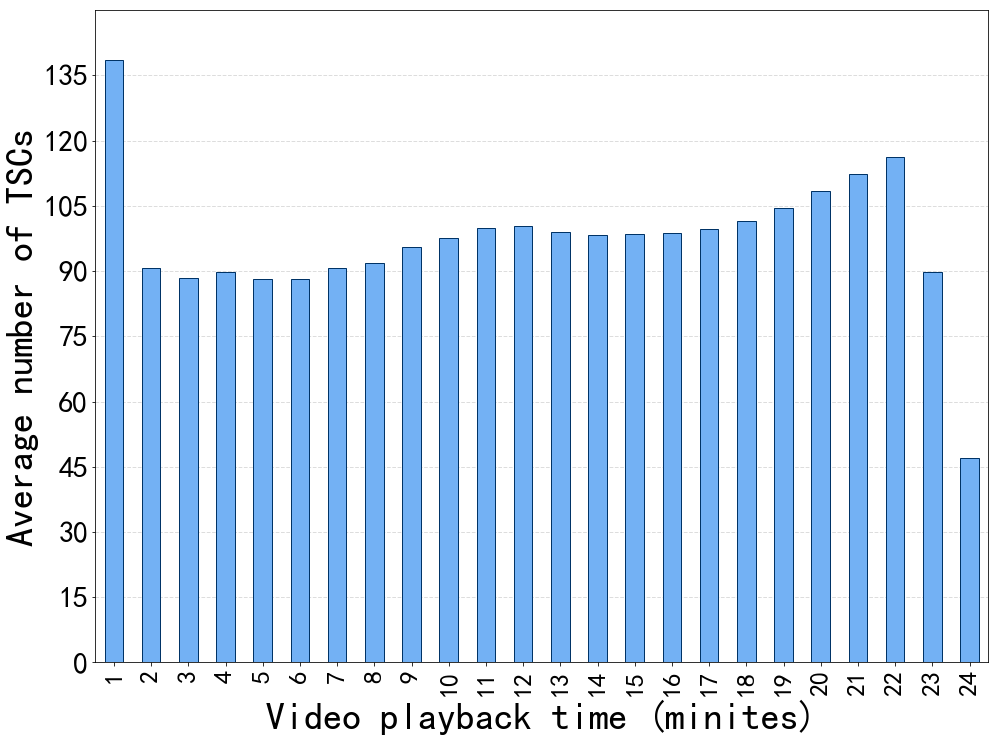

In [166]:
# Number of TSCs changing with video playback time (limited to 24-min length)
# run sql script in mysql beforehead

# -- create temporary tables
# create table episode_danmaku_cnt_dd
# 	as 
#  select episode_id, ceil(playback_time/60) as t_min
#     from danmaku ;


# create table episode_danmaku_cnt_summary
# 	as 
#  select episode_id, t_min, count(1) as danmaku_cnt
#     from episode_danmaku_cnt_dd
# group by episode_id, t_min ;



sql = 'select * from episode_danmaku_cnt_summary'
d_t_minute = pd.read_sql(sql,con=connect)

tmp = d_t_minute.groupby('t_min')['danmaku_cnt'].mean()[1:24]
tmp.index = tmp.index.astype(int)
tmp.plot(kind='bar',ylim=(20,150),figsize=(16,12), grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=30) 
mpl.rc('ytick', labelsize=30)
mpl.rcParams['axes.labelsize'] = 38
plt.yticks(np.arange(0, 150, 15))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Video playback time (minites)')
plt.ylabel('Average number of TSCs')
plt.savefig('Figure_4c.pdf', bbox_inches='tight')

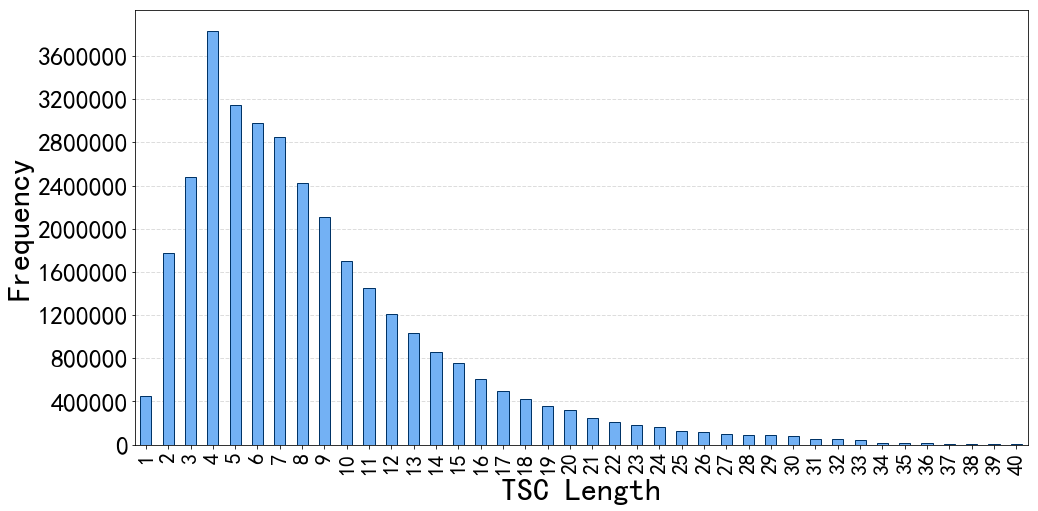

In [171]:
# Distribution of TSC length (limited to length ≤ 40)
danmaku_len_dist = pd.read_sql("select char_length(content) as danmaku_len, count(*) \
                                from danmaku group by char_length(content);",con=connect)
danmaku_len_dist.columns = ['danmaku_len','cnt']

danmaku_len_dist[:40].plot(
    x='danmaku_len', y='cnt', kind='bar', figsize=(16,8), legend=None, grid=False, color=BLUE, edgecolor=DARK_BLUE)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=24)
mpl.rcParams['axes.labelsize'] = 32
plt.yticks(np.arange(0, 4000000, 400000))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('TSC Length')
plt.ylabel('Frequency')
plt.savefig('Figure_4d.pdf', bbox_inches='tight')

In [147]:
#get word counts from file (preprocessed)
wc_result = pd.read_csv('wc_result_final.txt')

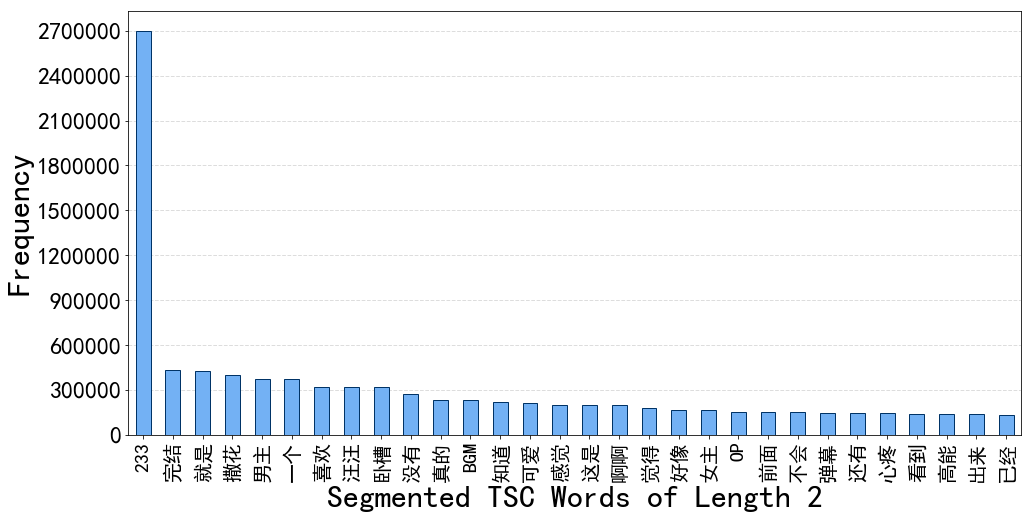

In [172]:
#
wc_plot1 = wc_result[wc_result.word_len>=2].head(30)
wc_plot1['count'].plot(figsize=(16,7.8), kind='bar', grid=False, color=BLUE, edgecolor=DARK_BLUE) \
    .set_xticklabels(wc_plot1['replaced'])
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=24)
mpl.rcParams['axes.labelsize'] = 32
plt.yticks(np.arange(0, 3000000, 300000))
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color=GRAY, linestyle='dashed', linewidth=1)
plt.xlabel('Segmented TSC Words of Length 2')
plt.ylabel('Frequency')
plt.savefig('Figure_4e.pdf', bbox_inches='tight')

In [ ]:
#total number of audience
pd.read_sql("select count(distinct sender_id) as usr_cnt from danmaku limit 10;",con=connect).iloc[0,0]

In [ ]:
#     create table sender_season_stats 
#     as 
#     select sender_id, count(1) as season_cnt 
#     from 
#     (
#         select sender_id, season_id
#         from 
#         (
#             select season_id, episode_id
#             from episode
#         )a
#         join 
#         (
#             select sender_id, episode_id
#             from danmaku 
#         )b 
#         on a.episode_id = b.episode_id
#         group by sender_id, season_id
#     )t
#     group by sender_id;

#average number of seasons per user watched
sender_season = pd.read_sql('select avg(season_cnt) from sender_season_stats',con=connect)
print('average number of seasons per user watched：{:.2f}'.format(sender_season.iloc[0,0]))

In [ ]:
#     create table sender_danmaku_stats 
#     as 
#     select sender_id, count(*) as danmaku_cnt
#         from danmaku 
#         group by sender_id;


#averge number of TSCs per user published
sql = '''
        select avg(danmaku_cnt) from sender_danmaku_stats;
'''
sender_danmaku = pd.read_sql(sql,con=connect)

print('averge number of TSCs per user published：{:.2f}'.format(sender_danmaku.iloc[0,0]))